# P2: Investigate a Dataset

## Titanic Data
**What factors made people more likely to survive?**

The disaster of the sinking of the Titanic is a well known historical event.  The detailed passenger manifest allows researchers a glimpse at the lives that were lost.  By analyzing what we know about each individual, an investigation can be conduced to understand what factors correlated with survival.

## Summary of data

Below is the data available regarding the passengers of the Titanic.

VARIABLE DESCRIPTIONS:
- survival:  Survival (0 = No; 1 = Yes)
- pclass:  Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
- name:  Name
- sex:  Sex
- age:  Age
- sibsp:  Number of Siblings/Spouses Aboard
- parch:  Number of Parents/Children Aboard
- ticket:  Ticket Number
- fare:  Passenger Fare
- cabin:  Cabin
- embarked:  Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

> Data source and descriptions from (https://www.kaggle.com/c/titanic/data)

In all, there are 891 unique passengers listed.

Several additional columns can be generated from this original data.
- embarked_port: Name of port of passenger embarked from
- salutation: Extracted from name, "Mr, Mrs, etc."
- passenger_group: Grouped by "Men, Women, and Children"
- has_family: Whether or not the passenger has family aboard (True, False)

The age feature had many missing values.  A possible solution for these missing values could be to impute the mean.  However, this would reinforce the existing mean and change the distribution of the data.  An alternative to this method is to use "passenger_group" feature that was created from related data.  This allows for analysis of age in more general groups, "men, women, and children".

Data cleaning and transformation details can be seen in notebook, [Data_Cleaning.ipynb](Data_Cleaning.ipynb).
Initial data exploration can been seen in notebook, [Data_Exploration.ipynb](Data_Exporation.ipynb).

## Visualizations of Survivability

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from scipy import stats
sns.set_color_codes()

In [3]:
df = pd.read_csv('titanic_data_cleaned.csv')


## Who Survived

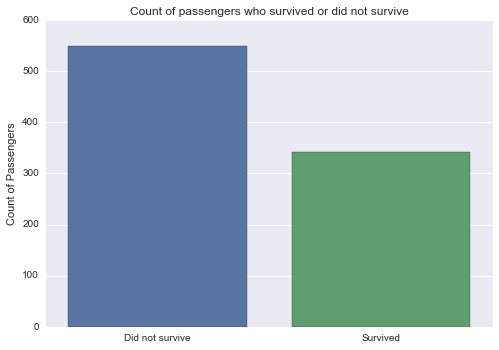

In [4]:
sns.countplot(data=df, x='Survived')
plt.title('Count of passengers who survived or did not survive')
plt.xticks([0, 1], ['Did not survive','Survived'])
plt.xlabel('')
plt.ylabel('Count of Passengers')

In [4]:
df.groupby('Survived', as_index=False).count()['PassengerId']

0    549
1    342
Name: PassengerId, dtype: int64

In [5]:
df['Survived'].mean()

0.3838383838383838

Of the 891 passengers aboard, only 342 survived, an overall survival rate of was 38.3%.

### Socioeconomic Status

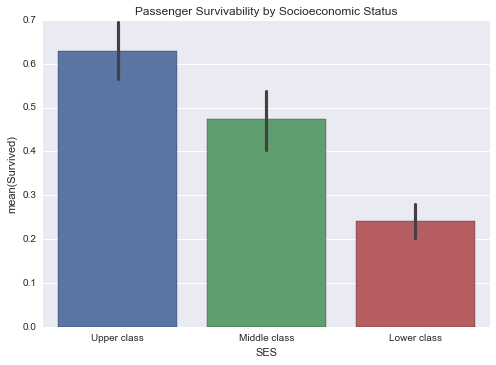

In [6]:
sns.barplot(data=df, x='ses', y='Survived', order=['Upper class','Middle class','Lower class'])
plt.title('Passenger Survivability by Socioeconomic Status')
plt.xlabel('SES')
plt.show()

The above plot shows the average survivability for a passenger based their class, with a 95% confidence interval.  There appears to be a high correlation between class an survival rate.  Higher class passengers have a higher survival rate while lower class passengers have a lower survival rate.

**Question**

> Did passengers in the upper class have a higher survival rate than those not in upper class?

**Define groups**

> **Upper Class Passengers**

> $\bar{X} = $ average survival rate for upper class

> $n_X = $ number of passengers in upper class

> $s_X = $ sample standard deviation of survival in upper class

> **Middle and Lower Class Passengers**

> $\bar{Y} = $ average survival rate for middle and lower class

> $n_Y = $ number of passengers in middle and lower class

> $s_Y = $ sample standard deviation of survival in middle and lower class

**Null Hypothesis**:  The sample means are equal.  There is no significant difference in survivability between the groups.

> $ H_0: \bar{X} = \bar{Y} $

**Alternative Hypothesis**:  The mean survivability for $X$ (upper class) will be greater than $Y$ (those not in upper class).

> $ H_A: \bar{X} > \bar{Y} $$

Compute sample statistics

In [32]:
df_chi = pd.pivot_table(df, values=['PassengerId'], index=['ses'], columns=['Survived'], aggfunc='count')
df_chi

PassengerId     
Survived               0    1
ses                          
Lower class          372  119
Middle class          97   87
Upper class           80  136

**Contincency Table**

||Did not survive|Survived:|Total:|
|-|-|-|
|Upper class|372|119|491|
|Middle class|97|87|184|
|Lower class|80|136|216|
|Total|549|342|891|


In [31]:
chi2, p, ddof, expected = stats.chi2_contingency(df_chi.values)
print 'chi2 = %s' % chi2
print 'p = %s' % p


chi2 = 102.888988757
p = 4.5492517113e-23


In [7]:
n_X = df[df['Pclass'] == 1].count()['Survived']
x_bar = df[df['Pclass'] == 1].mean()['Survived']
s_x = df[df['Pclass'] == 1].std()['Survived']

print 'Sample size for x:  n_X = %s' % n_X
print 'Sample mean for x:  x_bar = %.4f' % x_bar
print 'Sample std dev for x:  s_x = %.4f' % s_x

Sample size for x:  n_X = 216
Sample mean for x:  x_bar = 0.6296
Sample std dev for x:  s_x = 0.4840


In [8]:
n_Y = df[df['Pclass'] <> 1].count()['Survived']
y_bar = df[df['Pclass'] <> 1].mean()['Survived']
s_y = df[df['Pclass'] <> 1].std()['Survived']

print 'Sample size for Y:  b_Y = %s' % n_Y
print 'Sample mean for Y:  Y_bar = %.4f' % y_bar
print 'Sample std dev for Y:  s_Y = %.4f' % s_y

Sample size for Y:  b_Y = 675
Sample mean for Y:  Y_bar = 0.3052
Sample std dev for Y:  s_Y = 0.4608


Because the sample sizes for each group are large ($> 30$), an unpaired $t$-test is appropriate.  An $\alpha=.05$ significance level will be used.

Calculate the $t$ statistic for two independent samples value using pooled variance

$$ s^2_P = \frac {(n_X - 1)s^2_X + (n_Y - 1)s^2_Y } { n_X + n_Y - 2 }  $$

$$ t =   \frac{ \bar{X}-\bar{Y} }   { s_P \sqrt{ \frac{1}{n_X} + \frac{1}{n_Y} } }$$

In [9]:
# calculate t-critical value
t_crit = stats.t.isf(.05, n_X+n_Y-2)
print 't-critical value = %.4f' % t_crit

# calculate t-value
s2_p = (  ((n_X-1)*s_x**2) + ((n_Y-1)*s_y**2)  )  /  ( n_X+n_Y-2 )
t = (x_bar - y_bar) / (sqrt(s2_p)* sqrt( 1./n_X + 1./n_Y ) ) 
print 't-value = %.4f' %t

# calculate p-value (one-tailed)
p = stats.t.sf(t, n_X+n_Y-2)
print 'p-value = %s' % p

t-critical value = 1.6466
t-value = 8.8959
p-value = 1.59529112088e-18


Below is a visual of the results of the $t$-test.

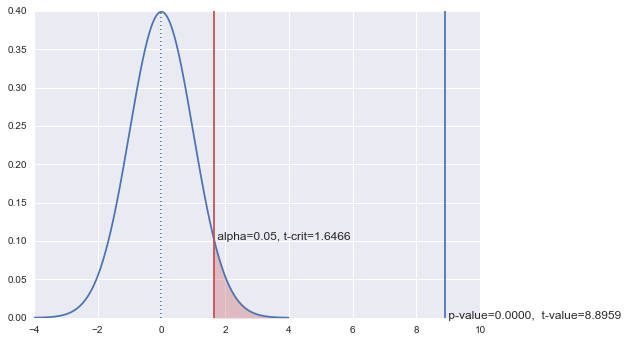

In [10]:
def t_plot(t_value, alpha, df):

    # plot the probability distribution function for t
    x = np.arange(-4, 4, .01)
    y = stats.t.pdf(x, df)
    
    plt.plot(x, y)
    plt.axvline(x=0, linestyle='dotted')
    
    # polt a vertical line for the t-critical value and shade the area below the curve
    t_crit = stats.t.isf(.05, df)
    plt.axvline(x=t_crit, color=sns.color_palette()[2])
    
    x_crit = np.arange(t_crit, 4, .01)
    y_crit = stats.t.pdf(x_crit, df)
    
    plt.fill_between(x_crit, y_crit, alpha=.3, color=sns.color_palette()[2])
    
    plt.text(x_crit[0], y_crit[0], ' alpha=%.2f, t-crit=%.4f' % (alpha,t_crit))
    
    # plot a vertical line for the t-value
    plt.axvline(x=t)
    p_value = stats.t.sf(t_value, df)
    plt.text(t_value, 0, ' p-value=%.4f,  t-value=%.4f' % (p_value, t_value))
    

t_plot(t_value=t, alpha=.05, df=n_X+n_Y-2)


The one-tailed critical value for $t$ at an $\alpha$ level of $.05$ with $n_X+n_Y-2=889$ degrees of freedom, is $1.6466$.

The calculated $t$-value is $8.8958$.  The null hypothesis should be rejected.  Since $8.8958 > 1.6466$, the alternative hypothesis should be accepted.

**Conclusion**

Upper class passengers had a significantly higher survival rate compared to those not in upper class.

**Further analysis**

The SciPy package can also calculate a two-sample independent $t$-test.

In [11]:
# calculate t test result using scipy
stats.ttest_ind(df[df['Pclass'] == 1]['Survived'], df[df['Pclass'] <> 1]['Survived'])

Ttest_indResult(statistic=8.8958643935890809, pvalue=3.1905822417529014e-18)

Same test stastitic is is returned.  *Note: P-value shown is for a two-tailed test.*

**Computing the Mann-Whitney U test result**

The non-parametric Mann-Whitney U test can also be performed to evaluate if the two samples were pulled from the same distribution.

Mann-Whitney U Test:

**Null hypothesis** The probability that the survivability of group X is greater than Y is .5.  More simply stated, it is equally likely that values of X are as big as the values of Y indicating no difference.
$$ H_0: P(X>Y) = 0.5 $$

**Alternative hypothesis** It is not equally likely that X will be greater than Y, indicating that the set of values in X is different that the set of values that make up Y.
$$ H_A: P(X>Y) \ne 0.5 $$

Sample size is large so we can standardize to a z score
$$ \mu_U = \frac{n_X n_Y}{2} $$ 
$$ \sigma_U = \frac{n_X n_Y(n_X+n_Y+1)}{12} $$
$$ z = \frac{U - \mu_U}{\sigma_U} $$

In [12]:
U, p_U = stats.mannwhitneyu(df[df['Pclass'] == 1]['Survived'], df[df['Pclass'] <> 1]['Survived'], alternative='greater')
print 'U value = %.f' % U
print 'p-value = %s' % p_U

U value = 96552
p-value = 7.37141042425e-18


In [13]:
mu_U = (n_X*n_Y)/2
print 'mu_U = %.4f' % mu_U

sigma_U = sqrt( (n_X*n_Y * (n_Y+n_Y+1))  /  12 )
print 'sigma_U = %.4f'% sigma_U

z = (U - mu_U) / sigma_U
print 'z = %.4f' % z

mu_U = 72900.0000
sigma_U = 4051.4997
z = 5.8378


At $\alpha=.05$, the $z$-critical value for a one tailed test is 1.96.  The standardized $z$-value for the Mann-Whitney U result is 5.8378, which is greater than the critical value.

The Mann-Whitney U test indicates the same result as the $t$ test.  The probability that the values in X are larger than the values from Y is greater than 50%.  Survivability for the upper class passengers is greater than those not in upper class.

### Family Groups

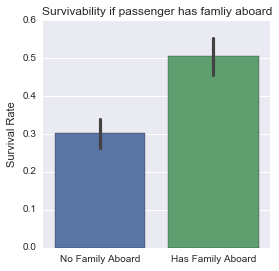

In [27]:
sns.factorplot(data=df, x='has_family', y='Survived', kind='bar')
plt.title('Survivability if passenger has famliy aboard')
plt.xticks([False, True],['No Family Aboard','Has Family Aboard'])
plt.xlabel('')
plt.ylabel('Survival Rate')
plt.show()

The above plot shows whether or not the passenger had family aboard the Titanic.  It appears that having family aboard is correlated with a higher survival rate.  A $t$ test can confirm this hypothesis.

**Question**

>Does having family aboard result in a different average survival rate?

**Define groups**

> **Passengers without family aboard**

> $\bar{X} = $ average survival rate for passengers without family aboard

> $n_X = $ number of passengers without family aboard

> $s_X = $ sample standard deviation of survival of passengers without family aboard

> **Passengers with family aboard**

> $\bar{Y} = $ average survival rate for passengers with family aboard

> $n_Y = $ number of passengers with family aboard

> $s_Y = $ sample standard deviation of survival of passengers with family aboard

**Null Hypothesis**:  The sample means are equal.  There is no significant difference in survivability between the groups.

> $ H_0: \bar{X} = \bar{Y} $

**Alternative Hypothesis**:  The mean survivability for $X$ (without family) will be less than $Y$ (with family).

> $ H_A: \bar{X} < \bar{Y} $

**Critical Values**
> $\alpha=.05$

> $t$-critical = $-1.6466$  (one-tailed test at 889 degrees of freedom)

Compute sample statistics

In [15]:
# calculate t test result using scipy
(t, p) = stats.ttest_ind(df[df['has_family'] == False]['Survived'], df[df['has_family'] == True]['Survived'])
print 't-value = %.4f' % t
print 'p-value (one-tail) = %s' % (p*2)

t-value = -6.1930
p-value (one-tail) = 1.80189803587e-09


The computed $t$-value is less than the $t$-critical value.  The null hypothesis should be rejected, and the alternative should be accepted.

**Conclusion**

> The survivability rate for passengers without family aboard is significantly lower than passengers with family aboard.

### Further analysis of family groups
By adding a secondary dimension of "passenger_group" (segmented by men, women, and children), the analysis that having family members aboard seems to be localized to children.

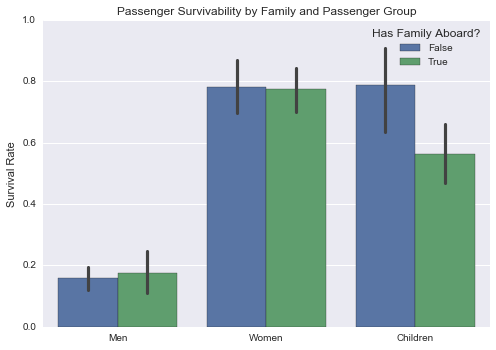

In [29]:
sns.barplot(data=df, x='passenger_group', y='Survived', hue='has_family')
plt.title('Passenger Survivability by Family and Passenger Group')
plt.ylabel('Survival Rate')
plt.xlabel('')
plt.legend(title='Has Family Aboard?')
plt.show()

Looking at a plot of whether or not the passenger has family aboard, individuals traveling with family had a higher survival rate.  When combined with if the passenger was a man, women, or child, the effect is mixed.  Men and women had similar survival rates whether or not they were traveling in family groups.  Children without families were more likely to survive.

Statistical tests can be conducted within these groups.

1. Men with family vs men without family
2. Women with family vs women without family
3. Children with family vs children without family

In the following statistical tests, let $X$ represent the group without family and $Y$ the group with family.

**Null hypothesis**

$H_0: \bar{X} = \bar{Y}$

**Alternative hypothesis**

$H_A: \bar{X} \ne \bar{Y}$

#### 1. Men with/without family

In [17]:
men_without_family = df[(df['passenger_group'] == 'Men') & (df['has_family'] == False)]['Survived']
men_with_family = df[(df['passenger_group'] == 'Men') & (df['has_family'] == True)]['Survived']

(t, p) = stats.ttest_ind(men_without_family, men_with_family)
print 't-value = %.4f' % t
print 'p-value = %.4f' % p

t_crit = stats.t.isf(.025, len(men_without_family)+len(men_with_family)-2)
print 't-critical value +/- %.4f' % t_crit


t-value = -0.4484
p-value = 0.6540
t-critical value +/- 1.9644


The $t$ value is $-1.9644 < -0.4484 < 1.9644$.  The null hypothesis should be accepted.

**Conclusion**

> There is no significant difference between men with family aboard and men without family aboard.

#### 2. Women with/without family

In [18]:
women_without_family = df[(df['passenger_group'] == 'Women') & (df['has_family'] == False)]['Survived']
women_with_family = df[(df['passenger_group'] == 'Women') & (df['has_family'] == True)]['Survived']

(t, p) = stats.ttest_ind(women_without_family, women_with_family)
print 't-value = %.4f' % t
print 'p-value = %.4f' % p

t_crit = stats.t.isf(.025, len(women_without_family)+len(women_with_family)-2)
print 't-critical value +/- %.4f' % t_crit

t-value = 0.1150
p-value = 0.9086
t-critical value +/- 1.9706


The $t$ value is $-1.9706 < -0.9086 < 1.9706$.  The null hypothesis should be accepted.

**Conclusion**

> There is no significant difference between women with family aboard and women without family aboard.

#### 3. Children with/without family

In [19]:
children_without_family = df[(df['passenger_group'] == 'Children') & (df['has_family'] == False)]['Survived']
children_with_family = df[(df['passenger_group'] == 'Children') & (df['has_family'] == True)]['Survived']

(t, p) = stats.ttest_ind(children_without_family, children_with_family)
print 't-value = %.4f' % t
print 'p-value = %.4f' % p

t_crit = stats.t.isf(.025, len(children_without_family)+len(children_with_family)-2)
print 't-critical value +/- %.4f' % t_crit

t-value = 2.3136
p-value = 0.0223
t-critical value +/- 1.9791


The $t$ value is $-1.9791 < 2.3136 \nless 1.9791$.  The null hypothesis should be rejected.

**Conclusion**

> There is a significant difference between children with family aboard and children without family aboard.

### Age
While there are missing values for age for several passengers, those individuals can be removed from the data set for analysis of the remainders.  The age of the passenger can be compared the individuals survivability through a violin plot which shows the distributions.

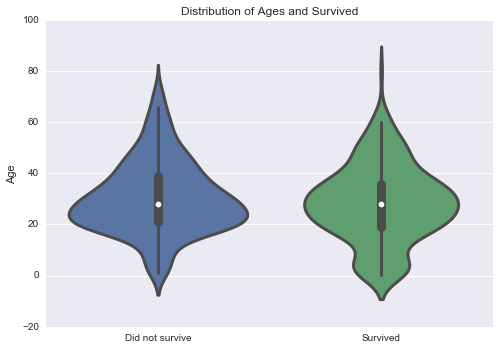

In [31]:
df_age = df[df['Age'].notnull()]
sns.violinplot(data=df_age, x='Survived', y='Age', linewidth=3)
plt.xticks([0, 1], ['Did not survive','Survived'])
plt.xlabel('')
plt.title('Distribution of Ages and Survived')

In [21]:
x_bar = df_age[df_age['Survived'] == 0].mean()['Age']
print 'Mean age (did not survive) = %.2f' % x_bar
y_bar = df_age[df_age['Survived'] == 1].mean()['Age']
print 'Mean age (survived) = %.2f' % y_bar

print 'Difference of means = %.2f' % (x_bar - y_bar)

Mean age (did not survive) = 30.63
Mean age (survived) = 28.34
Difference of means = 2.28


Visually, the distributions and centers of each distribution appear to be equal.  A $t$ test can confirm that the means of each group are not statistically different.

Let $X$ represent the age of passengers who did not survive, and $Y$ represent age of passengers who survived.

**Null hypothesis**

$ H_0: \bar{X} = \bar{Y} $  The mean age of passengers between the two groups is the same.

**Alternative hypothesis**

$ H_A: \bar{X} \ne \bar{Y} $  The mean age of passengers between the two groups is not the same.

In [22]:
age_not_survived = df_age[(df_age['Survived'] == 0)]['Age']
age_survived = df_age[(df_age['Survived'] == 1)]['Age']

(t, p) = stats.ttest_ind(age_not_survived, age_survived)
print 't-value = %.4f' % t
print 'p-value = %.4f' % p

t_crit = stats.t.isf(.025, len(age_not_survived)+len(age_survived)-2)
print 't-critical value +/- %.4f' % t_crit


t-value = 2.0667
p-value = 0.0391
t-critical value +/- 1.9633


The $t$ value is $-1.9633 < 2.0667 \nless 1.9633$.  The null hypothesis should be rejected and the alternative accepted.  

**Conclusion**

> The average age of passengers who did not survive is statistically different from the average age of passengers who survived.  While the difference in means is only $2.28$ years, the difference is statistically significant, although not particularly interesting.

# Conclusions

Several factors that were significantly correlated with survivability were socioeconomic class, whether or not the passenger had family aboard, and if the passenger was a man, woman, or child.  Passengers in upper class had a significantly higher survivability rate.  When analyzing if the passenger had family aboard, those that did had a higher survivability rate.  However, when combined if the passenger was a man, woman, or child, the correlation was isolated to children.  Men and women with or with family aboard had similar survival rates.  Children with out family aboard had a significantly different survival rate than those with family aboard.  When age was investigated, the mean age of survivors was statistically different from those who did not survive.  However, the difference of means was only 2.28 years.

This analysis shows a correlation between specific features or groups of features and survivability.  None of these findings can indicate a causal relations.  For example, being in upper class did not *cause* a passenger to survive.

**Feedback**
Results are clearly presented but there should be also a discussion with the shortcoming and limitations identified in your dataset, for example, Age column includes several missing values, how this affected your analysis? does it include any limitation? how did you handle these missing values?, did you consider alternative methods?,etc.


# References
> https://www.kaggle.com/c/titanic/data

> https://www.encyclopedia-titanica.org/titanic-deckplans/d-deck.html

> https://www.kaggle.com/c/titanic/forums/t/2955/how-do-you-cope-with-missing-values

> https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic/discussion

> https://www.analyticsvidhya.com/blog/2015/10/inferential-descriptive-statistics-beginners-r/